## Parameter optimization for KMeans Clustering of daily consumption patterns

In [2]:
import polars as pl
import glob
import numpy as np
import os
import logging
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import itertools

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation_kMeans
from Hyperparameters_KMeans import optimize_kmeans

dataset = "SWW"    # Options: "SWW", "GroupE"



In [ ]:
input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)        # z.B. "10030.csv"
    resid, _ = os.path.splitext(base)         # "10030"

    if len(df) != n_timestamps:
        continue

    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

train_data = data_3d
n_samples = data_3d.shape[0]

Shape of the 3D array: (1481, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [3]:
# Your data: numpy array of shape (n_samples, n_features)
X = train_data.squeeze()  # Adjust if 3D is (n_samples, n_timestamps, 1)

# Define grid of hyperparameters
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8],
    'init': ['k-means++', 'random'],
    'n_init': [1, 10, 20],
    'max_iter': [300, 500]
}


results = []

# Cartesian product of parameters
for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    # Calculate scores only if more than 1 cluster
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

# Results as a DataFrame, sorted by silhouette score (descending)
results_df = pd.DataFrame(results).sort_values(by='db_score', ascending=True)
print(results_df)

    n_clusters       init  n_init  max_iter  silhouette_score  db_score
17           4  k-means++      20       500          0.228020  1.340024
16           4  k-means++      20       300          0.228020  1.340024
15           4  k-means++      10       500          0.228020  1.340024
14           4  k-means++      10       300          0.228020  1.340024
23           4     random      20       500          0.227883  1.341188
..         ...        ...     ...       ...               ...       ...
65           8  k-means++      20       500          0.153623  1.643616
60           8  k-means++       1       300          0.150358  1.657942
61           8  k-means++       1       500          0.150358  1.657942
66           8     random       1       300          0.163699  1.676908
67           8     random       1       500          0.163699  1.676908

[72 rows x 6 columns]


In [11]:
X = train_data.squeeze()  # adjust shape if needed

param_grid = {
    'n_clusters': np.arange(1, 11, 1), 
    #'init': ['k-means++', 'random'],
    'init': ['k-means++'],
    'n_init': [1,3,5,7,9,11], 
    'max_iter': np.arange(100, 700, 100), 
}

results = []

for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

results_df = pd.DataFrame(results).sort_values(by='db_score', ascending=True)
print(results_df)

# Output best combination (highest silhouette score)
best_result = results_df.iloc[0]
print("\nBest combination of hyperparameters:")
print(best_result)

     n_clusters       init  n_init  max_iter  silhouette_score  db_score
92            4  k-means++       7       300          0.228020  1.340024
90            4  k-means++       7       100          0.228020  1.340024
91            4  k-means++       7       200          0.228020  1.340024
93            4  k-means++       7       400          0.228020  1.340024
94            4  k-means++       7       500          0.228020  1.340024
..          ...        ...     ...       ...               ...       ...
285           9  k-means++      11       400          0.163799  1.668350
286           9  k-means++      11       500          0.163799  1.668350
287           9  k-means++      11       600          0.163799  1.668350
265           9  k-means++       5       200          0.163799  1.668350
278           9  k-means++       9       300          0.163799  1.668350

[324 rows x 6 columns]

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_

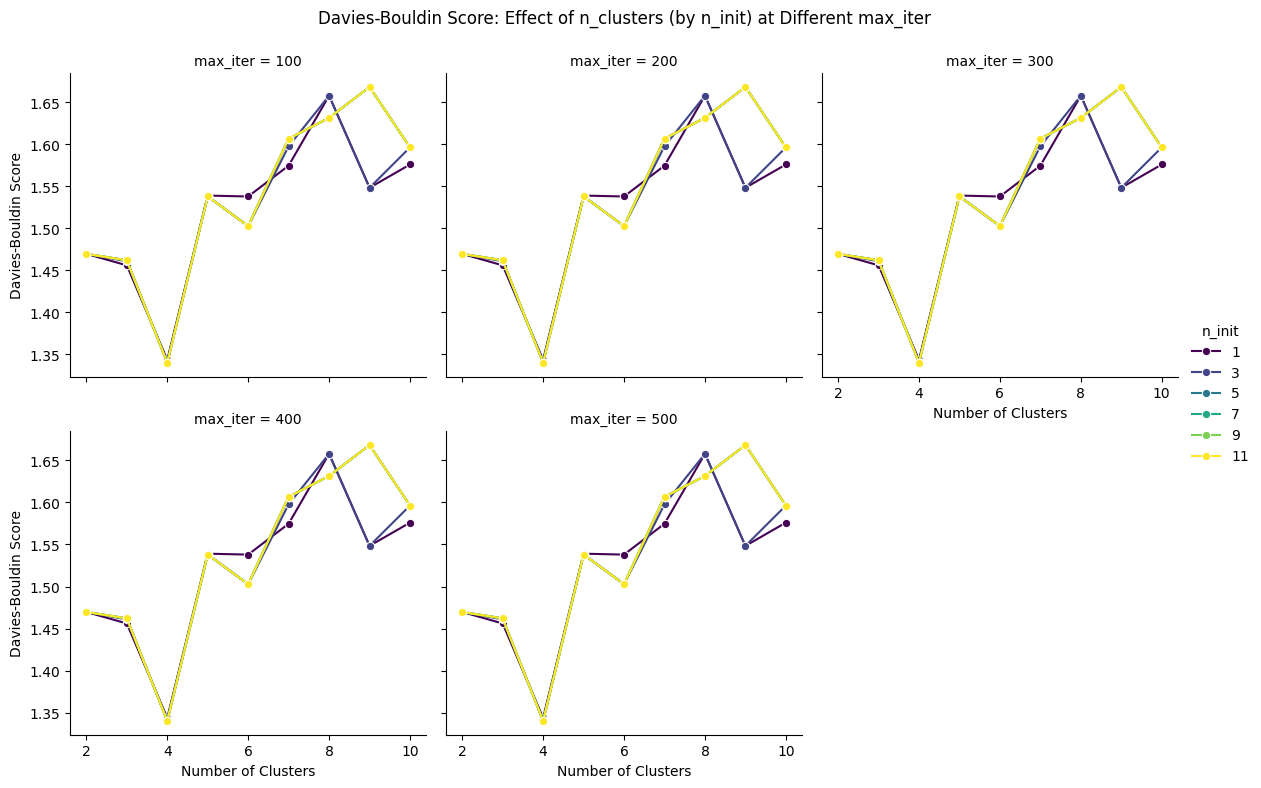

In [10]:
# Assuming results_df is your DataFrame with columns:
# 'n_clusters', 'n_init', 'max_iter', 'db_score'

# Example: Plot db_score vs n_clusters, colored by n_init, faceted by max_iter
g = sns.FacetGrid(results_df, col='max_iter', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='n_clusters', y='db_score', hue='n_init', marker='o', palette='viridis')

g.add_legend(title='n_init')
g.set_axis_labels('Number of Clusters', 'Davies-Bouldin Score')
g.set_titles(col_template='max_iter = {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Davies-Bouldin Score: Effect of n_clusters (by n_init) at Different max_iter')

plt.show()

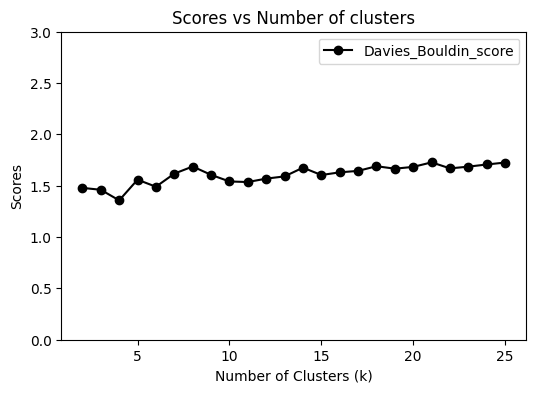

In [ ]:
validation_kMeans(train_data,train_data, "SWW")

In [3]:
optimize_kmeans(train_data)


Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      4
max_iter                  100
silhouette_score     0.227061
db_score             1.346645
Name: 65, dtype: object


n_clusters                  4
init                k-means++
n_init                      4
max_iter                  100
silhouette_score     0.227061
db_score             1.346645
Name: 65, dtype: object

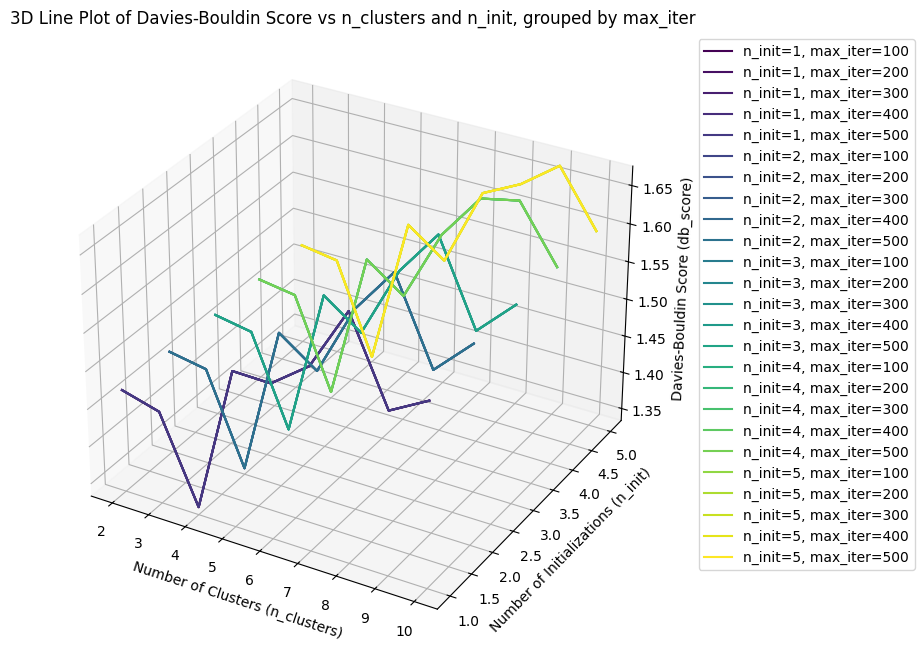

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required even if unused explicitly
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Assume results_df contains the data

# Get unique grouping values for lines (e.g., unique pairs of n_init and max_iter)
line_groups = results_df.groupby(['n_init', 'max_iter'])

colors = plt.cm.viridis(np.linspace(0, 1, len(line_groups)))

for (idx, ((n_init, max_iter), group)) in enumerate(line_groups):
    # Sort by n_clusters to get correct line order
    group_sorted = group.sort_values(by='n_clusters')
    ax.plot(
        group_sorted['n_clusters'],    # x
        np.full_like(group_sorted['n_clusters'], n_init),  # y fixed at n_init
        group_sorted['db_score'],      # z
        label=f'n_init={n_init}, max_iter={max_iter}',
        color=colors[idx]
    )

ax.set_xlabel('Number of Clusters (n_clusters)')
ax.set_ylabel('Number of Initializations (n_init)')
ax.set_zlabel('Davies-Bouldin Score (db_score)')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('3D Line Plot of Davies-Bouldin Score vs n_clusters and n_init, grouped by max_iter')

plt.show()